In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt


## Data Preprocessing

In [2]:
TRAINING_DIR = "Dataset/train"

train_datagen = ImageDataGenerator(
    rescale=1 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(150, 150),
                                                    subset='training')


Found 1238 images belonging to 3 classes.


In [3]:
validation_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                        batch_size=32,
                                                        class_mode='categorical',
                                                        target_size=(150, 150),
                                                        subset='validation')


Found 137 images belonging to 3 classes.


## Create Model

In [4]:
pre_trained_model = MobileNetV2(weights="imagenet", include_top=False,
                                input_tensor=Input(shape=(150, 150, 3)))

for layer in pre_trained_model.layers:
    layer.trainable = False

last_output = pre_trained_model.output

In [5]:
x = tf.keras.layers.AveragePooling2D(pool_size=(3, 3))(last_output)
x = tf.keras.layers.Flatten(name="flatten")(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.models.Model(pre_trained_model.input, x)

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 75, 75, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [6]:
int_lr = 1e-4
num_epochs = 20

optimizer = tf.optimizers.Adam(lr=int_lr, decay=int_lr/num_epochs)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


C:\Users\dicoding\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## Train Model

In [7]:
H = model.fit(train_generator,
              steps_per_epoch=20,
              epochs=num_epochs,
              validation_data=validation_generator,
              validation_steps=3)


Epoch 1/20
20/20 [==============================] - 23s 1s/step - loss: 1.8588 - accuracy: 0.4094 - val_loss: 1.0564 - val_accuracy: 0.4688
Epoch 2/20
20/20 [==============================] - 18s 898ms/step - loss: 1.4370 - accuracy: 0.4571 - val_loss: 0.9419 - val_accuracy: 0.5521
Epoch 3/20
20/20 [==============================] - 19s 945ms/step - loss: 1.2067 - accuracy: 0.5453 - val_loss: 0.7789 - val_accuracy: 0.6458
Epoch 4/20
20/20 [==============================] - 18s 934ms/step - loss: 1.0122 - accuracy: 0.5952 - val_loss: 0.8432 - val_accuracy: 0.6354
Epoch 5/20
20/20 [==============================] - 18s 918ms/step - loss: 0.9755 - accuracy: 0.6222 - val_loss: 0.8151 - val_accuracy: 0.6042
Epoch 6/20
20/20 [==============================] - 18s 923ms/step - loss: 0.8959 - accuracy: 0.6365 - val_loss: 0.8054 - val_accuracy: 0.6042
Epoch 7/20
20/20 [==============================] - 18s 921ms/step - loss: 0.8536 - accuracy: 0.6460 - val_loss: 0.7926 - val_accuracy: 0.7188
Ep

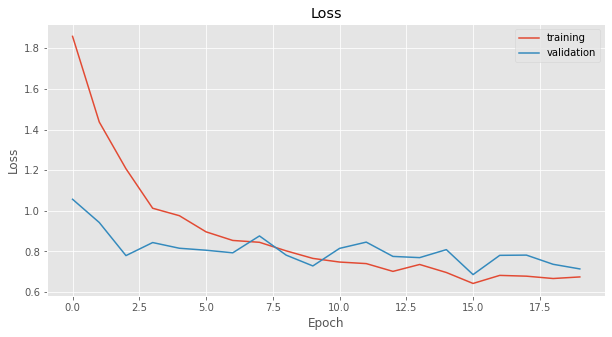

In [8]:
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, num_epochs), H.history["loss"], label="training")
plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


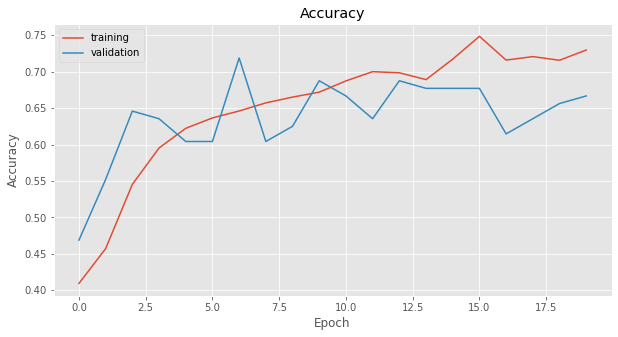

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="training")
plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()


## Mengubah Model

In [10]:
export_dir = 'saveed_model/'
tf.saved_model.save(model, export_dir)

model.save("model.h5")


INFO:tensorflow:Assets written to: saveed_model/assets


C:\Users\dicoding\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [11]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()


In [12]:
import pathlib
tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)


9516712